In [1]:
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn




df = pd.read_csv("hmda_sw-1.csv",delimiter=",")

print(df.isnull().sum())
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.nunique())
print(df.dtypes)



seq        0
s3         0
s4         0
s5         0
s6         0
          ..
vr         0
school     0
chval      0
dnotown    0
dprop      0
Length: 62, dtype: int64
0
seq        2380
s3            1
s4            1
s5            3
s6          302
           ... 
vr            2
school       27
chval       474
dnotown       2
dprop         1
Length: 62, dtype: int64
seq          int64
s3           int64
s4           int64
s5           int64
s6           int64
            ...   
vr           int64
school     float64
chval      float64
dnotown      int64
dprop        int64
Length: 62, dtype: object


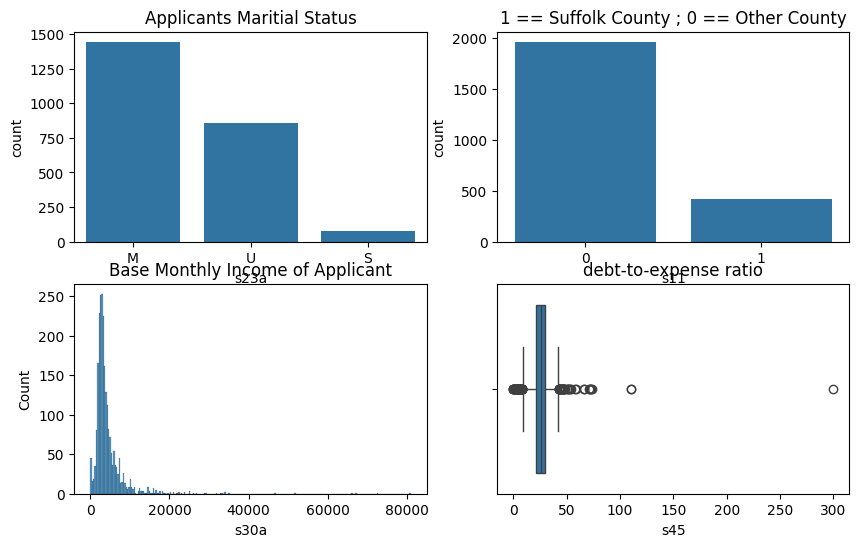

In [2]:

fig,axs = plt.subplots(2,2,figsize=(10,6))
sns.countplot(data=df,ax=axs[0,0],x='s23a')
axs[0,0].set_title("Applicants Maritial Status")

sns.countplot(data=df,ax=axs[0,1],x='s11')
axs[0,1].set_title("1 == Suffolk County ; 0 == Other County")

sns.histplot(data=df,ax=axs[1,0],x='s30a')
axs[1,0].set_title("Base Monthly Income of Applicant")

sns.boxplot(data=df,ax=axs[1,1],x='s45')
axs[1,1].set_title("debt-to-expense ratio")
plt.savefig("images/desc_stats1.png")
plt.show()

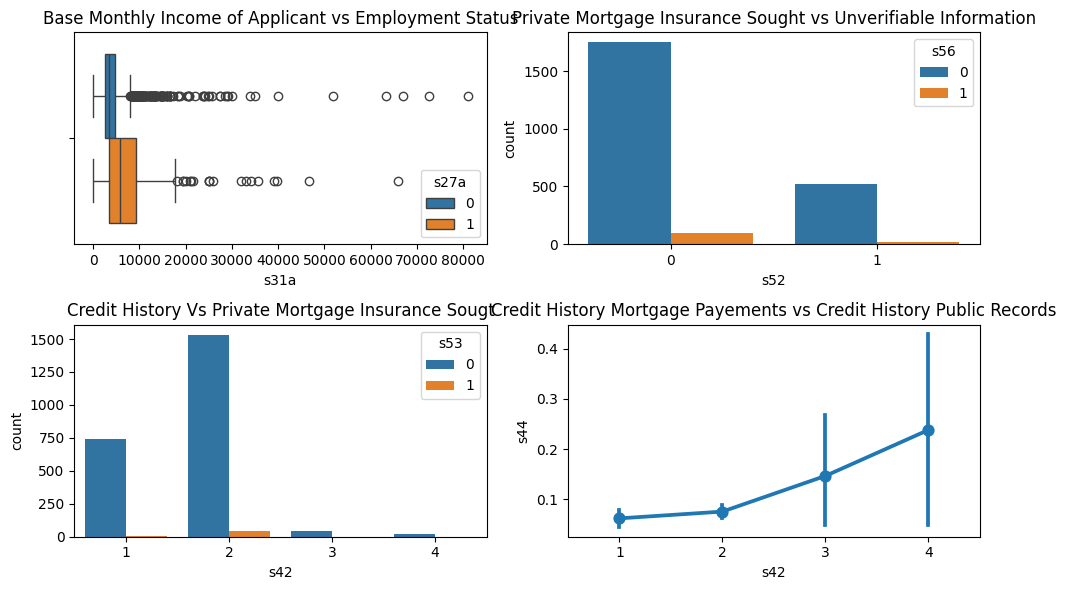

In [3]:
fig,axs = plt.subplots(2,2,figsize=(10,6))

sns.boxplot(data=df,ax=axs[0,0],x='s31a',hue="s27a")
axs[0,0].set_title("Base Monthly Income of Applicant vs Employment Status")

sns.countplot(data=df,ax=axs[0,1],x='s52',hue='s56')
axs[0,1].set_title("Private Mortgage Insurance Sought vs Unverifiable Information")

sns.countplot(data=df,ax=axs[1,0],x='s42',hue='s53')
axs[1,0].set_title("Credit History Vs Private Mortgage Insurance Sougt")

sns.pointplot(data=df,ax=axs[1,1],x="s42",y="s44")
axs[1,1].set_title("Credit History Mortgage Payements vs Credit History Public Records")
plt.tight_layout()
plt.savefig("images/des-stats2.png")
plt.show()


In [4]:

df.rename(columns={'s5':'occupancy','s7':'approved','s11':'county','s13':'race',
                   's15':'sex','s17':'income','s23a':'married','s27a':'self_employed',
                   's33':'purchase_price','s34':'other_financing','s35':'liquid_assets',
                   's40':'credit_history','s42':'chmp','s43':'chcp','s44':'chpr',
                   's45':'debt_to_expense','s46':'di_ratio','s50':'appraisal',
                   's53':'pmi_denied','netw':'net_worth','uria':'unemployment',
                   'school':'education','s56':'unverifiable',
                   's52':'pmi_sought'},inplace=True)



df['approved'] = [1 if X == 3 else 0 for X in df['approved']]
df['race'] = [0 if X == 3 else 1 for X in df['race']]
df['married'] = [1 if X == 'M' else 0 for X in df['married']]
df['sex'] = [1 if X == 1 else 0 for X in df['sex']]
df['credit_history'] = [1 if X == 1 else 0 for X in df['credit_history']]


df.drop(['seq','s3','s9','s14','s16','s18','s19a','s19b','s19c','s19d','s20','s48','s49','s54','dprop'],inplace=True,axis=1)







X_anova = df.drop('approved',axis=1)
y_anova = df['approved']

olsmodel = sm.OLS(exog=sm.add_constant(X_anova),endog=y_anova).fit()
print(olsmodel.summary())

                            OLS Regression Results                            
Dep. Variable:               approved   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     51.39
Date:                Tue, 17 Jun 2025   Prob (F-statistic):          1.44e-310
Time:                        18:32:34   Log-Likelihood:                 119.74
No. Observations:                2380   AIC:                            -147.5
Df Residuals:                    2334   BIC:                             118.2
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
s4                  0.2033      0.106     

In [5]:

"""Most relevant features from the anova table"""

selected_features = ['occupancy','race','sex','income','married','credit_history','di_ratio','pmi_denied','unverifiable','pmi_sought',"vr"]



""" using X and Y based on the most relevant features from the GLM anova table"""


X = df[selected_features]
y = df['approved']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def evaluate(y_test,pred,pred_prob,model_name,cv_scores):


    result = {
        "Model": model_name,
        "Accuracy": acc,
        "RocAucScore": roc,
        "CVscores": cv_scores.mean()
    }

    return result
    


dict_list = []

models = {
    "LogisticRegregression":LogisticRegression(),
    "BaggingClassifier":BaggingClassifier(),
    "RandomForestClassifier":RandomForestClassifier(),
    "GradientBoostingClassifier":GradientBoostingClassifier(),
    "KNN":KNeighborsClassifier(),
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "svc":SVC(probability=True),
    "xgb":XGBClassifier(objective="binary:logistic")
    }




    
    


for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)
    pred_prob = model.predict_proba(X_test_scaled)[:,1]
    acc = accuracy_score(y_test, pred)
    roc = roc_auc_score(y_test, pred_prob)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="roc_auc")
    evaluation_result = evaluate(y_test, pred, pred_prob, model_name, cv_scores)
    dict_list.append(evaluation_result)



df_results = pd.DataFrame(dict_list)


print(df_results)

                        Model  Accuracy  RocAucScore  CVscores
0       LogisticRegregression  0.943277     0.921492  0.915364
1           BaggingClassifier  0.936975     0.922037  0.850443
2      RandomForestClassifier  0.939076     0.916677  0.879627
3  GradientBoostingClassifier  0.932773     0.915651  0.903473
4                         KNN  0.922269     0.887723  0.852630
5      DecisionTreeClassifier  0.905462     0.809132  0.720290
6                         svc  0.941176     0.898505  0.867579
7                         xgb  0.936975     0.920257  0.867565


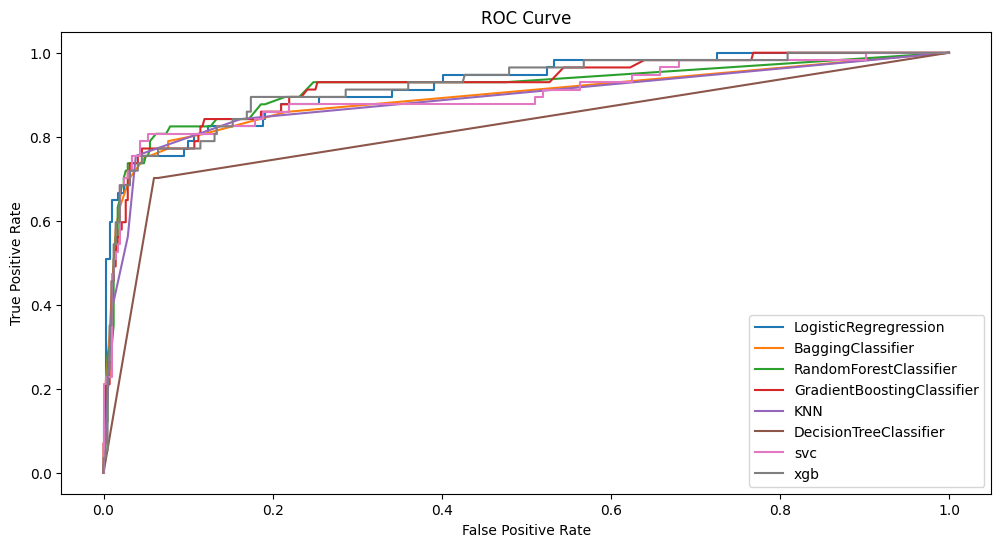

In [6]:

def plot_roc_curve(models,X_test_scaled,y_test):
    plt.figure(figsize=(12,6))
    
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        pred_prob = model.predict_proba(X_test_scaled)[:,1]
        fpr, tpr, _ = roc_curve(y_test, pred_prob)
        plt.plot(fpr, tpr, label=model_name)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig("images/roc-cures.png")
    plt.show()



plot_roc_curve(models, X_test_scaled, y_test)

In [7]:


mlflow.set_experiment("hmda-classifier-two")

lr_params = {
    'C': [0.001, 0.01, 0.1,1,10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'], 
    'max_iter': [1000, 5000, 10000]
}



gradient_boosting_params = {
    'n_estimators': [50,100,200],
    'learning_rate': [1,0.5,0.25,0.1,0.05,0.01],
    'max_depth': [3,4,5],
    'min_samples_split': [2,5,10],
}

random_forest_params = {
    'n_estimators': [50,100,200],
    'max_depth': [None,10,20],
    'min_samples_leaf':[1,2,4],
    'max_features': ['sqrt','log2',None],
    "criterion":["gini", "entropy"]
}



svc_params = {
    'C': [0.1,1,10,100,1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

bagging_classifier_params = {
    'n_estimators': [50,100,200],
    'max_samples' : [1.0,0.8,0.6],
    'max_features': [1.0,0.8,0.6]
}


knn_params = {
    'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']
               }



xgb_params = {
        'min_child_weight': [1,5,10],
        'gamma': [0.5,1,1.5,2,5],
        'subsample': [0.6,0.8,1.0],
        'colsample_bytree': [0.6,0.8,1.0],
        'max_depth': [3,4,5]
        }
    



models = {
    "LogisticRegression": (LogisticRegression(), lr_params),
    "RandomForestClassifier": (RandomForestClassifier(), random_forest_params),
    "GradientBoostingClassifier": (GradientBoostingClassifier(), gradient_boosting_params),
    "SVC": (SVC(probability=True), svc_params),
    "BaggingClassifier": (BaggingClassifier(), bagging_classifier_params),
    "KnnearestNeighnors":(KNeighborsClassifier(),knn_params),
    "xgboostingclassifier":(XGBClassifier(objective="binary:logistic"),xgb_params)
}


best_score = []


for model_name,(model,params) in models.items():
    print(f'GridSearch For {model_name}:')
    clf = GridSearchCV(model, params,cv=4,scoring="roc_auc",n_jobs=-1).fit(X_train_scaled,y_train)
    print(f'Best Parameters for {model_name} : {clf.best_params_}')
    print(f'Best Average RocAuc Scores for: {model_name} : {clf.best_score_ * 100:.2f}%')
    best_score.append({"Model":model_name,"RocScore":clf.best_score_})
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(clf.best_params_)
        mlflow.log_metric("best_score", clf.best_score_)
        mlflow.sklearn.log_model(clf.best_estimator_, model_name)
  

best_scores_df = pd.DataFrame(best_score)

print(best_scores_df.head())

2025/06/17 18:34:47 INFO mlflow.tracking.fluent: Experiment with name 'hmda-classifier-two' does not exist. Creating a new experiment.


GridSearch For LogisticRegression:
Best Parameters for LogisticRegression : {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Average RocAuc Scores for: LogisticRegression : 91.74%


2025/06/17 18:34:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/17 18:34:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GridSearch For RandomForestClassifier:


2025/06/17 18:35:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Parameters for RandomForestClassifier : {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 50}
Best Average RocAuc Scores for: RandomForestClassifier : 91.60%


2025/06/17 18:35:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GridSearch For GradientBoostingClassifier:


2025/06/17 18:35:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Parameters for GradientBoostingClassifier : {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}
Best Average RocAuc Scores for: GradientBoostingClassifier : 91.48%


2025/06/17 18:35:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GridSearch For SVC:


2025/06/17 18:35:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Parameters for SVC : {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Best Average RocAuc Scores for: SVC : 91.34%


2025/06/17 18:35:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GridSearch For BaggingClassifier:


2025/06/17 18:35:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Parameters for BaggingClassifier : {'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 200}
Best Average RocAuc Scores for: BaggingClassifier : 89.28%


2025/06/17 18:35:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GridSearch For KnnearestNeighnors:


2025/06/17 18:35:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Parameters for KnnearestNeighnors : {'metric': 'minkowski', 'n_neighbors': 15, 'weights': 'uniform'}
Best Average RocAuc Scores for: KnnearestNeighnors : 88.49%


2025/06/17 18:36:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GridSearch For xgboostingclassifier:


2025/06/17 18:36:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Parameters for xgboostingclassifier : {'colsample_bytree': 0.8, 'gamma': 1.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
Best Average RocAuc Scores for: xgboostingclassifier : 91.82%


2025/06/17 18:36:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


                        Model  RocScore
0          LogisticRegression  0.917389
1      RandomForestClassifier  0.915986
2  GradientBoostingClassifier  0.914751
3                         SVC  0.913359
4           BaggingClassifier  0.892832


In [8]:

logistic_regression = LogisticRegression(C=0.1,max_iter=1000,penalty='l2',solver="liblinear")
logistic_regression.fit(X_train_scaled,y_train)
lr_pred_prob = logistic_regression.predict_log_proba(X_test_scaled)[:,1]
print('Results From Optimal Logistic Regression model\n')
print(round(roc_auc_score(y_test, lr_pred_prob)*100,2))

Results From Optimal Logistic Regression model

92.3


In [9]:
joblib.dump(model,"models/model.joblib")

['models/model.joblib']